## This notebook visualizes the ElasticNet model performances via heatmap.
We visualize the model input feature coefficients and the model R2 scores.

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap)))
suppressPackageStartupMessages(suppressWarnings(library(reshape2)))
suppressPackageStartupMessages(suppressWarnings(library(ggplotify)))
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer)))
suppressPackageStartupMessages(suppressWarnings(library(circlize)))
suppressPackageStartupMessages(suppressWarnings(library(svglite)))


In [2]:
# set cell type
cell_type <- "PBMC"


In [3]:
# set path for data of all models
data_path <- file.path(paste0("../results/regression/", cell_type, "/", "all_model_performance.csv"))
df <- read.csv(data_path)
# setfigure path
figure_path <- file.path(paste0("../figures/regression/", cell_type, "/"))
# make the directory if it doesn't exist
dir.create(figure_path, recursive = TRUE, showWarnings = FALSE)


In [4]:
# select MMP-1 secreted protein as the target
df <- df %>% filter(shuffle == "final")


In [5]:
head(df,2)


,feature_names,coefficients,secreted_proteins,shuffle,cell_type,alpha,l1_ratio,r2
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Cells_Granularity_1_CorrDNA,-0.2977682,MMP-12 [NSU],final,PBMC,0.001,0.01,-0.4995399
2,Nuclei_Correlation_K_CorrMito_CorrPM,-0.1986651,MMP-12 [NSU],final,PBMC,0.001,0.01,-0.4995399


In [6]:
# get the feature names for color bar visualization 
features <- df %>% select(feature_names)
# drop duplicate features from the feature names
features <- unique(features)
features <- features %>%
        tidyr::separate(
            feature_names,
            into = c(
                "compartment",
                "feature_group",
                "measurement",
                "channel", 
                "parameter1", 
                "parameter2"
            ),
            sep = "_",
            remove = FALSE
        ) %>%
        dplyr::mutate(channel_cleaned = channel)

    # Clean channel for visualization
    features$channel_learned <- dplyr::recode(features$channel,
            "CorrDNA" = "nuclei",
            "CorrMito" = "Mito",
            "CorrER" = "ER",
            "CorrGasdermin" = "gasdermin",
            "CorrPM" = "PM",
            .default = "other",
            .missing="other"
    )


Warning message:
“Expected 6 pieces. Additional pieces discarded in 265 rows [8, 16, 17, 19, 22,
26, 31, 35, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 53, 54, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 329 rows [1, 2, 3, 4, 5,
6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 23, 24, 25, ...].”


In [7]:
r2_df <- df %>% select(r2)
r2_df <- unique(r2_df)
row_ha <- rowAnnotation(df = r2_df)
column_ha <- HeatmapAnnotation(Compartment = features$compartment, 
                               Feature_Type = features$feature_group, 

                               Channel = features$channel_learned, 
                               show_legend = TRUE)


In [8]:
# make the df into a matrix for heatmap
mat <- dcast(df, feature_names ~ secreted_proteins, value.var = "coefficients")
row.names(mat) <- mat$feature_names
mat <- mat %>% select(-feature_names)
mat <- as.matrix(mat)


In [9]:
# plot size
options(repr.plot.width=150, repr.plot.height=30)
model_heatmap <- (
        Heatmap(
        t(mat), 
        cluster_rows = TRUE,    # Cluster rows
        cluster_columns = TRUE, # Cluster columns
        show_row_names = TRUE,  # Show row names
        show_column_names = TRUE, # Show column names
        column_names_gp = gpar(fontsize = 12), # Column name label formatting
        row_names_gp = gpar(fontsize = 12),    # Row name label formatting
        right_annotation = row_ha,
        bottom_annotation = column_ha
        ) 
)
# ggplotify model_heatmap
model_heatmap <- as.ggplot(model_heatmap)
ggsave(file = paste0(figure_path, "all_features_heatmap.png"), plot = model_heatmap, width = 30, height = 30, units = "in", dpi = 500)
model_heatmap


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



## Plot the same heatmap above but on filterd data

In [10]:
# set path for data of all models
data_path <- file.path(paste0("../results/regression/", cell_type, "/", "all_model_performance.csv"))
df <- read.csv(data_path)
head(df)
# select MMP-1 secreted protein as the target
df <- df %>% filter(shuffle == "final")


,feature_names,coefficients,secreted_proteins,shuffle,cell_type,alpha,l1_ratio,r2
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Cytoplasm_AreaShape_Compactness,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396
2,Cells_Texture_InfoMeas2_CorrDNA_3_03_256,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396
3,Nuclei_AreaShape_Zernike_2_0,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396
4,Nuclei_AreaShape_Zernike_1_1,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396
5,Nuclei_AreaShape_Zernike_0_0,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396
6,Nuclei_AreaShape_Orientation,0,MMP-1 [NSU],shuffled,PBMC,10000,0.01,-0.00274396


In [11]:
# select rows that have r2 > 0.5
df <- df %>% filter(r2 > 0.5)
# filter rows that have coeff = 0
df <- df %>% filter(coefficients != 0)


In [12]:
# get the feature names for color bar visualization 
features <- df %>% select(feature_names)
# drop duplicate features from the feature names
features <- unique(features)
features <- features %>%
        tidyr::separate(
            feature_names,
            into = c(
                "compartment",
                "feature_group",
                "measurement",
                "channel", 
                "parameter1", 
                "parameter2"
            ),
            sep = "_",
            remove = FALSE
        ) %>%
        dplyr::mutate(channel_cleaned = channel)

    # Clean channel for visualization
    features$channel_learned <- dplyr::recode(features$channel,
            "CorrDNA" = "nuclei",
            "CorrMito" = "Mito",
            "CorrER" = "ER",
            "CorrGasdermin" = "gasdermin",
            "CorrPM" = "PM",
            .default = "other",
            .missing="other"
    )


Warning message:
“Expected 6 pieces. Additional pieces discarded in 265 rows [5, 47, 55, 69, 70,
71, 74, 78, 81, 82, 85, 91, 94, 97, 98, 99, 100, 102, 105, 106, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 329 rows [1, 2, 3, 4, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, ...].”


In [13]:
r2_df <- df %>% select(r2)
r2_df <- unique(r2_df)
row_ha <- rowAnnotation(
    df = r2_df,
    show_legend = TRUE,
    annotation_name_side = "top",
    # rotate the title
    annotation_legend_param = list(
        title_gp = gpar(fontsize = 16, angle = 0),
        labels_gp = gpar(fontsize = 16, angle = 0)
    ),
    # set color bar for r2 continuous value with brewer palette
    col = list(r2 = colorRamp2(c(0, 1), c(brewer.pal(9,"YlGn")[1], brewer.pal(9,"YlGn")[7])))
)                   


In [14]:
# make the df into a matrix for heatmap
mat <- dcast(df, feature_names ~ secreted_proteins, value.var = "coefficients")
row.names(mat) <- mat$feature_names
mat <- mat %>% select(-feature_names)
mat <- as.matrix(mat)
# na to 0
mat[is.na(mat)] <- 0
# drop rows that have 0 in 50% of the columns
mat <- mat[rowSums(mat != 0) > ncol(mat)/2, ]
mat <- as.data.frame(mat)
# get the feature names from the index
mat$feature_names <- row.names(mat)
# get the feature names for color bar visualization
features <- mat %>% select(feature_names)
# drop duplicate features from the feature names
features <- unique(features)
features <- features %>%
        tidyr::separate(
            feature_names,
            into = c(
                "compartment",
                "feature_group",
                "measurement",
                "channel", 
                "parameter1", 
                "parameter2"
            ),
            sep = "_",
            remove = FALSE
        ) %>%
        dplyr::mutate(channel_cleaned = channel)

    # Clean channel for visualization
    features$channel_learned <- dplyr::recode(features$channel,
            "CorrDNA" = "nuclei",
            "CorrMito" = "Mito",
            "CorrER" = "ER",
            "CorrGasdermin" = "gasdermin",
            "CorrPM" = "PM",
            .default = "other",
            .missing="other"
    )

# set annotations
column_ha <- HeatmapAnnotation(
    Compartment = features$compartment, 
    Feature_Type = features$feature_group, 
    Channel = features$channel_learned, 
    show_legend = TRUE,
    annotation_legend_param = list(title_position = "topcenter", title_gp = gpar(fontsize = 16, angle = 0), labels_gp = gpar(fontsize = 16, title = gpar(fontsize = 16))),
    annotation_name_side = "right",
    
    # color
    col = list(
        Compartment = c(
            "Cells" = brewer.pal(12, "Accent")[7], 
            "Cytoplasm" = brewer.pal(12, "Accent")[6], 
            "Nuclei" = brewer.pal(12, "Accent")[5]
        ),
        Feature_Type = c(
            "AreaShape" = brewer.pal(12, "Paired")[1], 
            "Correlation" = brewer.pal(12, "Paired")[2], 
            "Granularity" = brewer.pal(12, "Paired")[5], 
            "Neighbors" = brewer.pal(12, "Paired")[8], 
            "RadialDistribution" = brewer.pal(12, "Paired")[10], 
            "Texture" = brewer.pal(12, "Paired")[11]
        ),
        # manually define the color for each channel to match the wavelegnth-ish
        Channel = c(
            "nuclei" = "#0000AB",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "gasdermin" = "#FFFF00",
            "PM" = "#C90000",
            "other" = "#B09FB0")
    )
)
                
# drop the feature names column
mat <- mat %>% select(-feature_names)
mat <- as.matrix(mat)


Warning message:
“Expected 6 pieces. Additional pieces discarded in 3 rows [23, 24, 25].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 21 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, ...].”
Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”
Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”
Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



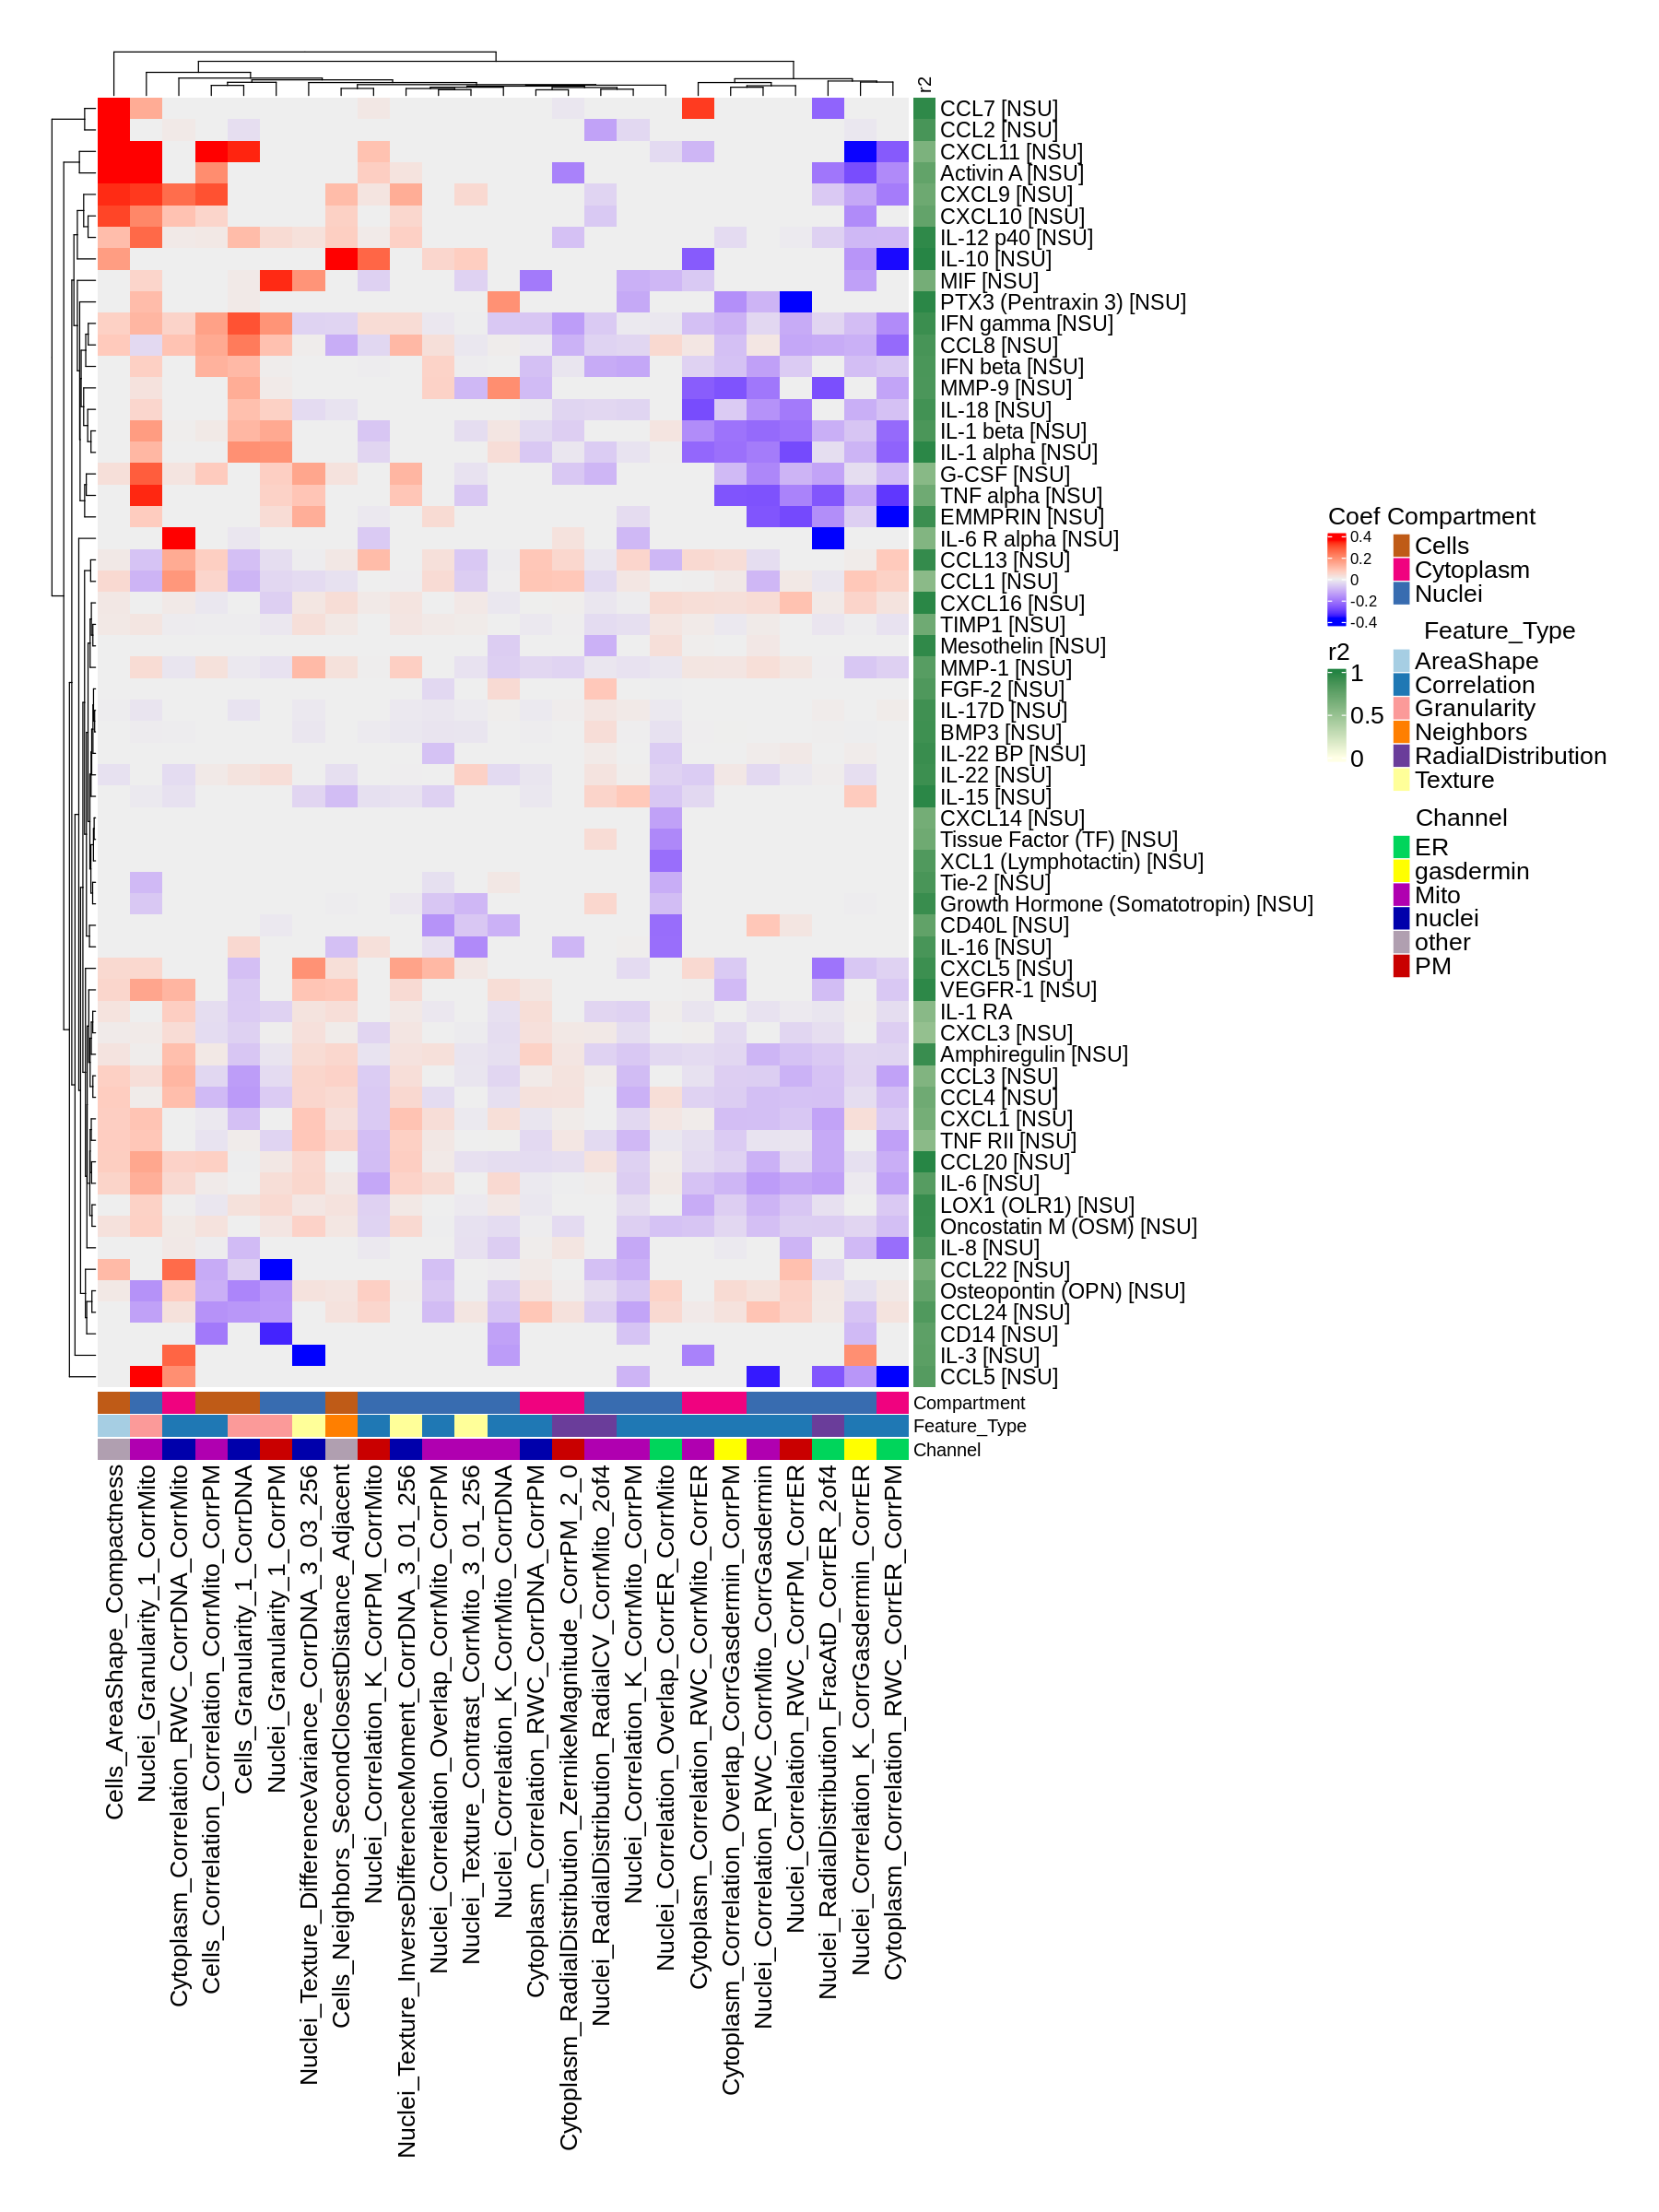

In [15]:
# plot size
options(repr.plot.width=15, repr.plot.height=20)
# change margins
par(mar = c(1, 1, 1, 1))

model_heatmap <- (
        Heatmap(
        t(mat), 
        cluster_rows = TRUE,    # Cluster rows
        cluster_columns = TRUE, # Cluster columns
        show_row_names = TRUE,  # Show row names
        show_column_names = TRUE, # Show column names
        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14),    # Row name label formatting
        right_annotation = row_ha,
        bottom_annotation = column_ha,
        # rename fill legend
        heatmap_legend_param = list(title = "Coef", title_position = "topcenter", title_gp = gpar(fontsize = 16)),
        column_names_max_height = unit(7, "in"),
        row_names_max_width = unit(5.5, "in"),
        # color bar text size bigger
        )     
)

# ggplotify model_heatmap
model_heatmap <- as.ggplot(model_heatmap)
model_heatmap <- model_heatmap +   theme(plot.margin = unit(c(1, 1, 1, 1), "cm"))

# save the figure
ggsave(file = paste0(figure_path, "filtered_features.svg"), plot = model_heatmap, width = 15, height = 20, units = "in", dpi = 500)
ggsave(file = paste0(figure_path, "filtered_features.png"), plot = model_heatmap, width = 15, height = 20, units = "in", dpi = 500)

model_heatmap
